# Setup

In [1]:
%matplotlib inline

In [2]:
!jt -t gruvboxd -T -tf firacode -tfs 16 -mathfs 110 -fs 16

In [3]:
from ipywidgets import interact
import ipywidgets as widgets

In [4]:
import qgrid

In [5]:
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

ColorPicker(value='blue', description='Pick a color')

In [22]:
import sys
import os as os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from numpy.random import RandomState
from scipy.stats import gamma, beta, uniform, binom
from scipy.integrate import solve_ivp
import time

rand = RandomState()

In [7]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

# Functions and classes

In [8]:
%%bash 
source activate dynamic_survival_analysis

In [9]:
from epidemiccore_w import *

In [10]:
def compute_density(epi,theta):
    S0 = [1]
    sol = odeint(Epidemic.Deriv_S, S0, epi.t, args=tuple(theta))
    S = interp1d(epi.t,sol[:,0])
    a,b,c = theta    
    out = []
    ST = S(epi.T)
    for x in epi.t:
        Sx = S(x)
        out.append((a*Sx*np.log(Sx)+b*(Sx-Sx**2)+c*Sx)/(1-ST))
    return out

In [11]:
def plot_density_fit_posterior(epi, samples):
    nSamples = np.size(samples, axis = 0)
    Ds = np.zeros((nSamples, len(epi.t)), dtype=np.float)
    for idx in range(nSamples):
        Ds[idx] = compute_density(epi, samples[idx])
    Dslow = np.quantile(Ds, q = 0.025, axis=0)
    Dshigh = np.quantile(Ds, q = 0.975, axis=0)
    Dmean = np.mean(Ds, axis=0)
    fig = plt.figure()
    plt.plot(epi.t, Dmean, '-', color=myColours['tud7d'].get_rgb(), lw=3)
    plt.plot(epi.t, Dslow, '--', color=myColours['tud7d'].get_rgb(), lw=1)
    plt.plot(epi.t, Dshigh, '--', color=myColours['tud7d'].get_rgb(), lw=1)
    plt.axvline(x=epi.T, color=myColours['tud11d'].get_rgb(), linestyle='-')

    mirrored_data = (2 * epi.T - epi.df['infection'].values).tolist()
    combined_data = epi.df['infection'].values.tolist() + mirrored_data
    dense = gaussian_kde(combined_data)
    denseval = list(dense(x) * 2 for x in epi.t)
    plt.plot(epi.t, denseval, '-', color=myColours['tud1d'].get_rgb(), lw=3)
    plt.fill_between(epi.t, Dslow, Dshigh, alpha=.3, color=myColours['tud7d'].get_rgb())
    plt.legend()
    plt.ylabel('$-S_t/(1-S_T)$')
    plt.xlabel('t')
    c = cumtrapz(Dmean, epi.t)
    ind = np.argmax(c >= 0.001)
    plt.xlim((epi.t[ind], epi.t[-1] + 1))

    return fig

In [85]:
def poisson_ode_fun(t, S, a, b, c):
    dsdt = np.float64(- a * S * np.log(S, dtype=np.float64) - b * (S - S * S) - c * S)
    return dsdt

In [205]:
def poisson_trans_ode(t, S, a, b, rho):
    dsdt = np.float64(- a * S * np.log(S, dtype=np.float64) - b * (S - S * S) - b * rho * S)
#     dsdt = -(b*S*(1.0+rho) - b*S*S + a*S*np.log(S, dtype=np.float64))
    return dsdt

In [174]:
def euler1d(odefun, t, ic=1.0, abc=(0.4,0.6,1E-6)):
    stepsize = t[1] - t[0]
    sol = np.zeros(len(t), dtype=np.float64)
    sol[0] = ic
    a,b,c = abc
    f = lambda S: odefun(t, S, a, b, c)
    for i in range(1,len(t)):
        sol[i] = sol[i-1] + np.float64(f(sol[i-1])) * stepsize
    return sol

In [175]:
def prevalence_loglikelihood(prev_data, T, parms):
    a, b, rho = parms
    step_size = 0.01
    t = np.linspace(0.0, T, 1000)
#     sol = solve_ivp(poisson_trans_ode, [0.0, T], y0= [1.0], args=tuple(parms))
    sol = euler1d(poisson_trans_ode, t, abc=(a, b, c))
    S = interp1d(t, sol)
    nsuccess, nfail = prev_data
    n = nsuccess + nfail
    if T > 21:
        p = (S(T-21) - S(T))/(1-S(T))
    else:
        p = 1.0
    return binom.logpmf(nsuccess, n, p)

In [184]:
def log_data_likelihood(df, theta):
    a, b, rho = theta
    S0 = [1.0]
    T = np.max(df.values)
    t = np.linspace(0.0,T,1000)
    sol = euler1d(poisson_trans_ode, t, abc=(a, b, rho))
    S = interp1d(t, sol)
    smax = S(T)
    factor = 1 - smax
    Z = 0
    j = 0
    for x in df.values:
        s = S(x)
        if s > 0:
            z = (a*s*np.log(s, dtype=np.float64)+b*(s-s**2)+b*rho*s)/factor
            if z > 0:
                Z += np.log(z, dtype=np.float64)
                j += 1
    return -Z

In [216]:
parms = (0.4, 0.6, 1e-9)
step_size = 0.01
T = 100.0
timepoints = np.linspace(0.0, T, 1000)
sol = solve_ivp(poisson_trans_ode, [0.0, T], 
                y0 = [1.0], 
                dense_output = True, 
                args = (0.4, 0.6, 1e-15)) 

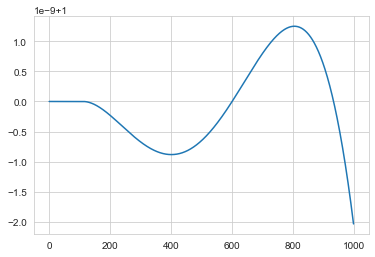

In [217]:
z = sol.sol(timepoints)
fig = plt.figure()
plt.plot(z.T)

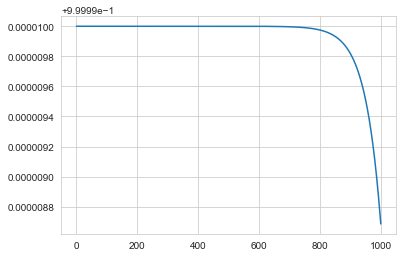

In [219]:
sol2 = euler1d(poisson_trans_ode, timepoints,
               abc=(0.4, 0.6, 1e-15))
fig = plt.figure()
plt.plot(sol2)

In [224]:
z.T - 1.0

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-2.22044605e-16],
       [-2.22044605e-16],
       [-3.33066907e-16],
       [-3.33066907e-16],
       [-4.44089210e-16],
       [-5.55111512e-16],
       [-5.55111512e-16],
       [-6.66133815e-16],
       [-6.66133815e-16],
       [-7.77156117e-16],
       [-8.88178420e-16],
       [-8.88178420e-16],
       [-9.99200722e-16],
       [-1.11022302e-15],
       [-1.22124533e-15],
       [-1.22124533e-15],
       [-1.33226763e-15],
       [-1.44328993e-15],
       [-1.55431223e-15],
       [-1.66533454e-15],
       [-1.66533454e-15],
       [-1.77635684e-15],
       [-1.88737914e-15],
       [-1.99840144e-15],
       [-2.10942375e-15],
       [-2.22044605e-15],
       [-2.33146835e-15],
       [-2.44249065e-15],
       [-2.55351296e-15],
       [-2.66453526e-15],
       [-2.77555756e-15],
       [-2.88657986e-15],
       [-2.99760217e-15],
       [-3.10862447e-15],
       [-3.21964677e-15],
       [-3.33066907e-15],
       [-3.4

In [141]:
root_folder = os.getcwd()
plot_folder = os.path.join(root_folder,'plots')
data_folder = os.path.join(root_folder,'data')
server_folder = os.path.join(root_folder,'data')

In [142]:
today = pd.to_datetime(np.datetime64('2020-04-04 00:00:00'))

In [143]:
today = pd.to_datetime('today')

# Dynamic Survival Analysis for Italy

In [144]:
location = 'italy'

In [145]:
fname_for_server = location + '_' + today.strftime("%m%d") + '.csv'

In [146]:
datafile = 'Italy0413.csv'
df_italy = pd.read_csv(os.path.join(data_folder,datafile), parse_dates=["time"])

In [147]:
day0 = pd.to_datetime(df_italy.time.min())
print(day0)

2020-02-06 00:00:00


In [148]:
# get daily counts
df_italy_inf = df_italy['cum_confirm'].diff().abs()
df_italy_inf[0] = df_italy['cum_confirm'].iloc[0]
df_italy['daily_confirm'] = df_italy_inf

In [149]:
inf_count = df_italy['cum_confirm'].values
death_count = df_italy['cum_dead'].values
cure_count = df_italy['cum_heal'].values

# get daily recovery counts 
df_italy_cure = df_italy['cum_heal'].diff().abs()
df_italy_cure[0] = df_italy['cum_heal'].iloc[0]
df_italy['recovery'] = df_italy_cure

# get daily death counts
df_italy_death = df_italy['cum_dead'].diff().abs()
df_italy_death[0] = df_italy['cum_dead'].iloc[0]
df_italy['deaths'] = df_italy_death

In [150]:
df_italy.to_csv(os.path.join(server_folder,fname_for_server), index=False)

In [151]:
location = 'Italy'  
datafile = fname_for_server
estimate_gamma = True
ifMPI = True
ifsmooth = False
last_date = pd.to_datetime(np.datetime64('2020-04-13 00:00:00'))
burn_in = 5000
nChains = 1

In [152]:
dsa_dict = {'datafile': datafile,
            'location': location,
            'plot_folder': today.strftime("%m%d") + '_plots_dsa',
            'last_date': last_date,
            'estimate_gamma': estimate_gamma,
            'ifsmooth': ifsmooth,
            'ifMPI': ifMPI}

laplace_dict = {'datafile': datafile,
                'location': location,
                'plot_folder': today.strftime("%m%d") + '_plots_laplace',
                'ifMPI': ifMPI,
                'last_date': last_date,
                'estimate_gamma': estimate_gamma,
                'ifsmooth': ifsmooth}

ifMPI = False
mh_dict = {'datafile': datafile,
            'location': location,
            'plot_folder': today.strftime("%m%d") + '_plots_mh',
            'ifMPI': ifMPI,
            'last_date': last_date,
            'estimate_gamma': estimate_gamma,
            'ifsmooth': ifsmooth,
            'burn_in': burn_in,
            'nChains': nChains}

fname = 'dsa_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(server_folder, fname),"wb")
pickle.dump(dsa_dict,f)
f.close()

fname = 'laplace_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(server_folder, fname),"wb")
pickle.dump(laplace_dict,f)
f.close()

fname = 'mh_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(data_folder,fname),"wb")
pickle.dump(mh_dict,f)
f.close()

In [153]:
laplace_dict

{'datafile': 'italy_0421.csv',
 'location': 'Italy',
 'plot_folder': '0421_plots_laplace',
 'ifMPI': True,
 'last_date': Timestamp('2020-04-13 00:00:00'),
 'estimate_gamma': True,
 'ifsmooth': False}

In [154]:
## smoothing counts
df_italy["rolling_mean"] = df_italy.daily_confirm.rolling(window=3).mean()
df_italy["rolling_mean"] = df_italy.apply(lambda dd: dd.daily_confirm if np.isnan(dd.rolling_mean)
                                                   else dd.rolling_mean, axis=1)

if ifsmooth:
    print('Generating infection times by uniformly distributing throughout each day from smoothed daily counts\n')
    infection_data = list(
        i + rand.uniform() for i, y in enumerate(df_italy['rolling_mean'].values) for z in range(y.astype(int)))
    df = pd.DataFrame(infection_data, index=range(len(infection_data)), columns=['infection'])
else:
    print('Generating infection times by uniformly distributing throughout each day from actual daily counts\n')
    infection_data = list(
        i + rand.uniform() for i, y in enumerate(df_italy['daily_confirm'].values) for z in range(y.astype(int)))
    df = pd.DataFrame(infection_data,index=range(len(infection_data)),columns=['infection'])


Generating infection times by uniformly distributing throughout each day from actual daily counts



In [155]:
## set up prior
a = expon(scale=0.4)
b = expon(scale=0.6)
c = expon(scale=1E-5)
p = [a,b,c]

In [156]:
plot_T = 150
N = min(500,df_italy['cum_confirm'].iloc[-1])
n = 40
bounds = [(0.3,0.50),(0.51,0.70),(1E-9,1E-3)]

#a_prior = expon(scale=0.4)
#b_prior = expon(scale=0.6)
#c_prior = expon(scale=1E-5)
a_prior = uniform(loc=bounds[0][0], scale=bounds[0][1])
b_prior = uniform(loc=bounds[1][0], scale=bounds[1][1])
c_prior = uniform(loc=bounds[2][0], scale=bounds[2][1])
p = [a_prior, b_prior, c_prior]

ic = [a_prior.rvs(), b_prior.rvs(), c_prior.rvs()]
print(ic)

epiT = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(ic),plot_T=plot_T, p=p)

[0.7656831183574525, 0.5642816575798797, 0.0005454640519013106]


In [157]:
epiT.n

58030153.64111174

In [159]:
#epiT.laplace_fit(N=N, summary = True)
epiT.fit(N=N, summary = True)

/Users/khudabukhsh.2/Dropbox/COVID-19-Caleb/python/wasiur/dynamic_survival_analysis/epidemiccore_w.py:1852: RuntimeWarning: divide by zero encountered in double_scalars
  Theta[1] = Theta[1] + d
/Users/khudabukhsh.2/Dropbox/COVID-19-Caleb/python/wasiur/dynamic_survival_analysis/epidemiccore_w.py:1862: RuntimeWarning: divide by zero encountered in double_scalars
  Theta = np.copy(theta)
/Users/khudabukhsh.2/Dropbox/COVID-19-Caleb/python/wasiur/dynamic_survival_analysis/epidemiccore_w.py:1873: RuntimeWarning: divide by zero encountered in double_scalars
  


Parameter    Name                                   MLE  Mean      StdErr
-----------  ------------------------  ----------------  ------  --------
T            final time                    68
a            beta+gamma+delta               0.5                       inf
b            beta*mu                        0.564282                  inf
c            beta*mu*rho                    0.000545464               inf
R0           R-naught                       1.12856
rho          initial fraction I             0.000966652
tau          epidemic size                  0.225772
1-S(T)       rescaling                      0.173815
n            #S+#I                     899594
kT           #I(T)                     156363
sT           #S(T)                     743231
kinfty       #I(infty)                 203103
sinfty       #S(infty)                 696491
1/rho        initial total population    1034.5
gamma        recovery rate
offset       shift parameter


In [191]:
epiT.boundc

(1e-09, 0.001)

In [194]:
x0 = [0.24, 0.66, 1e-4]
bounds = [[0.01, 1.0], [0.01,1.0], [1e-9, 1e-3]]
objfxn = lambda theta: log_data_likelihood(df, theta)
minobj = minimize(objfxn, x0= tuple(x0),
        bounds=bounds)
print(minobj)
a, b, rho = minobj.x 

      fun: array([574846.6217271])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([   403.0065611 ,    763.40511441, 108042.91814566])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 16
   status: 0
  success: True
        x: array([3.85771538e-01, 5.35325373e-01, 5.94802665e-05])


In [196]:
R0 = b/a
c = b * rho
print(R0)
print(c)

1.387674622393993
3.1841295890499035e-05


In [ ]:
poisson_ode_fun(1e-28, 0.1, abc=(0.3,0.78,1e-1))

In [ ]:
sol = euler1d(poisson_ode_fun, epiT.t, abc=(0.24, 0.85, 1e-6))

In [ ]:
f = plt.figure()
plt.plot(sol)

In [ ]:
epiT.fit(N=N, summary=True)

In [ ]:
epiT.laplace_objfxn([0.4,0.6, 1E-5])

In [ ]:
f = plt.figure()
plt.plot(epiT.t,compute_density(epiT, epiT.theta))

## Fitted parameters

In [ ]:
fname = "fitted_parms_" + today.strftime("%m%d") + '.csv' 
fitted_parms = pd.read_csv(os.path.join('Italy',fname))
fitted_parms

In [ ]:
temp = np.zeros((3, np.size(fitted_parms,0)), dtype=np.float)
temp[0] = fitted_parms.a.values
temp[1] = fitted_parms.b.values
temp[2] = fitted_parms.c.values
mean_estimates = np.mean(fitted_parms, axis=0)
s = np.std(fitted_parms, axis=0)
theta = np.mean(temp,axis=1)
cov = np.cov(temp)
print('The mean values of the posterior samples are\n')
print(mean_estimates)

print('The standard deviations of the posterior samples are\n')
print(s)

print('The estimated covariance matrix is\n')
print(cov)

In [ ]:
f = plt.figure()
plt.hist(fitted_parms.a.values, bins=10)

g = plt.figure()
plt.hist(fitted_parms.b.values, bins=10)

In [ ]:
samples = fitted_parms[['a','b', 'c']].to_numpy()

In [ ]:
nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})

nSim = 5000
samples = parm_sample_correlated(theta,cov,nSim)
samples

In [ ]:
fname = location + '_epi_' + today.strftime("%m%d") + '.pkl'
epiT = pickle.load(open(os.path.join('Italy', fname), "rb"))

In [ ]:
fig_density = plot_density_fit_posterior(epiT, samples)
fname = location + 'Tfinaldensity' + today.strftime("%m%d")
fig_save(fig_density, plot_folder, fname)

In [ ]:
fname = location + 'predictions_' + today.strftime("%m%d")
#fname = 'test'
predictions = predict(epiT, samples, df_italy, dates, plot_folder, fname)

In [ ]:
def peak_s(s, abc):
    a, b, c = abc
    L = a + b + c 
    return L - 2 * b * s + a * np.log(s, dtype=np.float64)

def peak_t(t, abc):
    a, b, c = abc
    L = a + b + c
    sol = euler1d(poisson_ode_fun, epiT.t, abc=tuple(epiT.theta))
    S = interp1d(epiT.t, sol) 
    x = sc.optimize.broyden1(lambda s: peak_s(s, abc), [0.5], f_tol=1e-14)
    return S(t) - x

In [ ]:
x = sc.optimize.broyden1(peak_s, [0.5], f_tol=1e-14)

In [ ]:
peak_time = sc.optimize.broyden1(lambda t: peak_t(t, epiT.theta), [40.5], f_tol=1e-14)

In [ ]:
peak_times = peak_time_hist(samples)

In [ ]:
fname = 'peaktime_hist' + today.strftime("%m%d")
fig = plt.figure()
plt.hist(peak_times, bins=20, density=True, color=myColours['tud3a'].get_rgb())
fig_save(fig, plot_folder, fname)

In [ ]:
def peak_time_hist(samples):
    peak_times = np.zeros(np.size(samples, axis=0), dtype=np.float64)
    for i in range(np.size(samples, axis=0)):
        peak_times[i] = sc.optimize.broyden1(lambda t: peak_t(t, samples[i]), [40.5], f_tol=1e-14)
    return peak_times

## Recovery times

In [ ]:
print('Generating recovery times by uniformly distributing throughout each day')
recovery_data = list(
    i + rand.uniform() for i, y in enumerate(df_italy['recovery'].values + df_italy['deaths'].values) for z in
    range(y.astype(int)))
df_recovery = pd.DataFrame(recovery_data, index=range(len(recovery_data)), columns=['recovery'])

In [ ]:
fname = location + "_gamma_fitted_" + today.strftime("%m%d") + ".csv"
fitted_recovery_params = pd.read_csv(os.path.join('Italy', fname))
fitted_recovery_params

In [ ]:
temp = np.zeros((2, np.size(fitted_recovery_params,0)), dtype=np.float)
temp[0] = fitted_recovery_params.gamma.values
temp[1] = fitted_recovery_params.offset.values

recov_mean_estimates = np.mean(fitted_recovery_params, axis=0)
recov_s = np.std(fitted_recovery_params, axis=0)
recov_theta = np.mean(temp,axis=1)
recov_cov = np.cov(temp)
print('The mean values of the posterior samples are\n')
print(recov_mean_estimates)

print('The standard deviations of the posterior samples are\n')
print(recov_s)

print('The estimated covariance matrix is\n')
print(recov_cov)

In [ ]:
fig = plt.figure()
plt.hist(fitted_recovery_params.gamma.values, bins=25, density=True)

In [ ]:
fig = plt.figure()
plt.hist(fitted_recovery_params.offset.values, bins=25, density=True)

In [ ]:
nSim = 100
recov_parm_samples = parm_sample_correlated(recov_theta,recov_cov,nSim)
recov_parm_samples

In [ ]:
bounds=[(1.0 / 25, 1.0 / 5), (-10, 0)] 
approach='offset'

density_gamma = recovery_density_fit(epiT, df_recovery, recov_parm_samples)

In [ ]:
fname = location + "recoverydensity" + today.strftime("%m%d") 
fig_save(density_gamma, plot_folder, fname)

In [ ]:
np.size(recov_parm_samples,0)

In [ ]:
estimate_gamma_sample(epiT, epiT.theta, df_recovery = df_recovery, N=N, x0=(0.1, -5),
                                       bounds=[(1.0 / 25, 1.0 / 5), (-10, 0)], approach='offset')

In [ ]:
def estimate_gamma_sample(epi, sample, df_recovery, N,x0,bounds,approach='gamma'):
    # solve the system over the relevant timespan
    S0 = [1.0]
    t = epi.plot_T
    if approach == 'offset':
        t += bounds[1][1]
    tt = np.linspace(0,t,1000)
    sol = odeint(Epidemic.Deriv_S, S0, tt, args=tuple(sample))
    S = interp1d(tt,sol[:,0])
    Scure = S
    Tcure = np.ceil(df_recovery['recovery'].max())
    datacure = df_recovery['recovery'].sample(N,replace=True).values

    if approach == 'offset':
        bounds_gamma = bounds
        # perform optimization
        gamma, offset = minimize(
            epi.negloglikelihood_gammaoffset,
            x0=x0,
            bounds=bounds_gamma,
            options={'disp': False, 'maxiter':3}
        ).x
    elif approach == 'prior':
        # perform optimization
        bounds_gamma = bounds
        offset = 0
        # perform optimization
        alpha, beta = minimize(
            epi.negloglikelihood_alphabeta,
            x0=x0,
            bounds=bounds_gamma,
            options={'disp': False, 'maxiter':3}
        ).x
        gamma = alpha * beta
    elif approach == 'gamma':
        offset = 0
        bounds_gamma = bounds
        # perform optimization
        gamma, = minimize(
            epi.negloglikelihood_gamma,
            x0=x0,
            bounds=bounds_gamma,
            options={'disp': False, 'maxiter':3}
        ).x
    return gamma, offset


In [ ]:
def recovery_density_fit(epi, df_recovery, samples):  
    nSamples = np.size(samples, axis=0)
    S0 = [1.0]
    t = epi.plot_T
    if approach == 'offset':
        t += bounds[1][1]
    tt = np.linspace(0,t,1000)
    sol = euler1d(poisson_ode_fun, tt, abc=tuple(epi.theta))
    S = interp1d(tt, sol)     
    Scure = S
    Tcure = np.ceil(df_recovery['recovery'].max())
    datacure = df_recovery['recovery'].sample(N,replace=True).values    
    s = np.linspace(Tcure/100, Tcure,100).tolist()
    s_ = np.asarray([0]+s)
    
    mirrored_data = (2*Tcure - df_recovery['recovery'].values).tolist()
    combined_data = df_recovery['recovery'].values.tolist() + mirrored_data
    dense = gaussian_kde(combined_data)
    denseval = [0]+list(dense(u)*2 for u in s[1:])
    cumdensity_data = cumtrapz(denseval,s,initial=0)
    cumdensity_data /= cumdensity_data[-1]
    ind3 = np.argmax(cumdensity_data>0.001)
    ind4 = np.argmax(cumdensity_data>0.999)
    fig = plt.figure()
    for idx in range(nSamples):
        gamma, offset = samples[idx]
        vals = np.asarray([0]+list(epi.proper_density_recovery(u, gamma,offset=offset) for u in s))     
        cumdensity_model = cumtrapz(vals,s_,initial=0)
        cumdensity_model /= cumdensity_model[-1]
        ind1 = np.argmax(cumdensity_model>0.001)
        ind2 = np.argmax(cumdensity_model>0.999)
        low = min(ind1,ind3)
        high = max(ind2,ind4)
        plt.plot(s_[low:high+1],vals[low:high+1],'-', color= myColours['tud7a'].get_rgb(), lw=1.5, alpha = 0.5)
        
    vals = np.asarray([0]+list(epi.proper_density_recovery(u, epi.gamma,offset=epi.offset) for u in s))     
    cumdensity_model = cumtrapz(vals,s_,initial=0)
    cumdensity_model /= cumdensity_model[-1]
    ind1 = np.argmax(cumdensity_model>0.001)
    ind2 = np.argmax(cumdensity_model>0.999)
    low = min(ind1,ind3)
    high = max(ind2,ind4)
    plt.plot(s_[low:high+1],vals[low:high+1],'-', color= myColours['tud7d'].get_rgb(), lw=3, alpha = 0.5)

    plt.plot(s[low:high+1],denseval[low:high+1],'-', color = myColours['tud2d'].get_rgb(), lw=3)
    plt.xlabel('t')
    plt.ylabel('Probability')
    plt.axvline(x=epi.Tcure,color=myColours['tud11d'].get_rgb(),linestyle='-')

    return fig

In [ ]:
epiT.offset

In [ ]:
plot_T = 150
N = min(2000,df_italy['cum_confirm'].iloc[-1])
n = 40
bounds = [(0.3,0.5),(0.5,0.7),(1E-9,1E-1)]

epiT = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(theta),plot_T=plot_T)

In [ ]:
epiT.fit(N=N, summary=True)

In [ ]:
fname = location + 'Tfinaldensity' + today.strftime("%m%d")
fig_save(fig_density, plot_folder, fname)

In [ ]:
def estimate_n(df, theta):
    epi = Epidemic(file_or_df = df, abc=theta)
    return epi.n

In [ ]:
estimate_n(epiT.df, [0.4, 0.6, 1E-6])

In [ ]:
def predict(epi, samples, ohio_df, dates, Plot_Folder, fname):
    nSamples = np.size(samples,axis=0)
    nDays = len(dates)
    time_points = np.arange(nDays)
    mean = np.zeros((nSamples, nDays), dtype=np.float)
    mean_daily = np.zeros((nSamples, nDays), dtype=np.float)
    theta = np.mean(samples,axis=0)
    n = epi.n
   # n = np.mean(diagnostics(tuple(theta), ohio_df))
    fig = plt.figure()
    for i in range(nSamples):
        S0 = [1]
        n = estimate_n(epi.df, samples[i])
#         n = np.mean(diagnostics(tuple(samples[i]), ohio_df))
        sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(samples[i]))
        S = interp1d(time_points, sol[:, 0])
        mean[i] = np.asarray(list(n * (1 - S(x)) for x in time_points))
        mean[i][0] = 1
        mean_daily[i] = np.append(mean[i][0], np.diff(mean[i]))
        l1, = plt.plot(dates['d'].dt.date, mean[i], '-', color=myColours['tud2b'].get_rgb(), lw=1, alpha=0.05)
        # l1nd = plt.plot(dates['d'].dt.date, mean_nd[i], '-', color=myColours['tud7a'].get_rgb(), lw=1, alpha=0.05)

    m_ = np.int64(np.ceil(np.mean(mean, axis=0)))
    l = np.int64(np.ceil(np.quantile(mean, q= 0.025, axis=0)))
    h = np.int64(np.ceil(np.quantile(mean, q= 0.975, axis=0)))

    S0 = [1]
    n = estimate_n(epi.df, epi.theta)
   # n = np.mean(diagnostics(tuple(theta), ohio_df))

    sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(theta))
    S = interp1d(time_points, sol[:, 0])
    m = np.asarray(list(n * (1 - S(x)) for x in time_points))
    l2 = plt.plot(dates['d'].dt.date, m, '-', color=myColours['tud1d'].get_rgb(), lw=3)
#     l2_, = plt.plot(dates['d'].dt.date, m_, '-', color=myColours['tud1d'].get_rgb(), lw=3, label='With mitigation')
    l3 = plt.plot(dates['d'].dt.date, l, '--', color=myColours['tud1d'].get_rgb(), lw=1)
    l4 = plt.plot(dates['d'].dt.date, h, '--', color=myColours['tud1d'].get_rgb(), lw=1)
    l5 = plt.fill_between(dates['d'].dt.date, l, h, alpha=.1, color=myColours['tud1a'].get_rgb())

    l6 = plt.axvline(x=ohio_df['time'].max(), color=myColours['tud7d'].get_rgb(), linestyle='--')
    l6 = plt.axvline(x=ohio_df['time'][epi.T - 1], color=myColours['tud7a'].get_rgb(), linestyle='-')
    l7 = plt.plot(ohio_df['time'].values, ohio_df['cum_confirm'].values, '-', color=myColours['tud7d'].get_rgb(), lw=3)
    plt.xlabel('Dates')
    plt.ylabel('Cumulative infections')
    # plt.legend(handles=[l2nd_, l2_])
#     plt.legend((l2_,l2nd_), ('Mean with mitigation', 'Mean without mitigation'))
    fig_save(fig, Plot_Folder, fname)

    fname_ = fname + '_daily_new'
    fig = plt.figure()
    for i in range(nSamples):
        # l1nd = plt.plot(dates['d'].dt.date, mean_nd_daily[i], '-', color=myColours['tud7b'].get_rgb(), lw=1, alpha=0.05)
        l1 = plt.plot(dates['d'].dt.date, mean_daily[i], '-', color=myColours['tud2b'].get_rgb(), lw=1, alpha=0.05)
    m_daily = np.append(m[0], np.diff(m))
    # m_nd_daily = np.append(m_nd[0], np.diff(m_nd))
    # l2nd, = plt.plot(dates['d'].dt.date, m_nd_daily, '-', color=myColours['tud7d'].get_rgb(), lw=3, label='Without mitigation')
    l2, = plt.plot(dates['d'].dt.date, m_daily, '-', color=myColours['tud1d'].get_rgb(), lw=3, label='With mitigation')
    l6 = plt.axvline(x=ohio_df['time'].max(), color=myColours['tud7d'].get_rgb(), linestyle='--')
    l6 = plt.axvline(x=ohio_df['time'][epi.T - 1], color=myColours['tud7a'].get_rgb(), linestyle='-')
    # l7 = plt.plot(df_ohio['time'].values, df_ohio['daily_confirm'].values, color=myColours['tud11d'].get_rgb(), lw=3)
    plt.ylabel('Daily new infections')
    plt.xlabel('Dates')
    # plt.legend(handles=[l2nd, l2])
    fig_save(fig, Plot_Folder, fname_)
    m[0] = 1
    # m_nd[0] = 1
    my_dict = {}
    my_dict['Dates'] = dates['d']
    my_dict['Mean'] = m
    my_dict['High'] = h
    my_dict['Low'] = l
    my_dict = pd.DataFrame(my_dict)
    my_dict.to_csv(os.path.join(Plot_Folder, fname + '.csv'), index=False)
    return my_dict


## Posterior samples using Laplace approximation

In [ ]:
fname = location + '_fits_' + today.strftime("%m%d") + '.csv'
thetas_fitted = pd.read_csv(os.path.join('Italy',fname))
thetas_fitted

In [ ]:
fname

In [ ]:
temp = np.zeros((3, np.size(thetas_fitted,0)), dtype=np.float)
temp[0] = thetas_fitted.a.values
temp[1] = thetas_fitted.b.values
temp[2] = thetas_fitted.c.values
mean_estimates = np.mean(thetas_fitted, axis=0)
s = np.std(thetas_fitted, axis=0)
theta = np.mean(temp,axis=1)
cov = np.cov(temp)
print('The mean values of the posterior samples are\n')
print(mean_estimates)

print('The standard deviations of the posterior samples are\n')
print(s)

print('The covariance matrix is\n')
print(cov)

In [ ]:
f = plt.figure()
plt.hist(thetas_fitted.a.values, bins=20)
plt.hist(thetas_fitted.b.values, bins=20)

In [ ]:
f = plt.figure()
plt.hist(thetas_fitted.R0.values, bins=20, density=True)

In [ ]:
nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})

nSim = 100
samples = parm_sample_correlated(theta,cov,nSim)
samples

In [ ]:
temp = thetas_fitted[['a','b','c']].to_numpy()
idx = np.random.choice(np.size(temp,axis=0), 1000)
samples = temp[idx]
samples

In [ ]:
fig_density = plot_density_fit_posterior(epiT, samples)

## Metropolis-Hastings

In [ ]:
mh_folder = today.strftime("%m%d") + '_plots_mh'
fname = 'mh_chains' + today.strftime("%m%d")
mh_chains = pickle.load(open(os.path.join(mh_folder, fname), "rb"))
mh_chains

In [ ]:
len(mh_chains['a'])

In [ ]:
temp = np.zeros((3, len(mh_chains['a'])), dtype=np.float)
temp[0] = mh_chains['a']
temp[1] = mh_chains['b']
temp[2] = mh_chains['c']
mean_estimates = np.mean(temp, axis=1)
s = np.std(temp, axis=1)
theta = np.mean(temp,axis=1)
cov = np.cov(temp)
print('The mean values of the posterior samples are\n')
print(mean_estimates)

print('The standard deviations of the posterior samples are\n')
print(s)

print('The covariance matrix is\n')
print(cov)

In [ ]:
f = plt.figure()
plt.hist(mh_chains['a'], bins=20, density=True)

In [ ]:
nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})

nSim = 5000
samples = parm_sample_correlated(theta,cov,nSim)
samples

In [ ]:
fname = location + 'predictions_' + today.strftime("%m%d")
fname = 'test'
predictions = predict(epiT, samples, df_italy, dates, plot_folder, fname)

In [ ]:
epiT.bounda

In [ ]:
len(thetas_fitted)

In [ ]:
fname = os.path.join('Italy',"thetas_fitted")
thetas_fitted = pickle.load(open(fname, "rb"))
thetas_fitted

In [ ]:
all_theta = thetas_fitted[['a','b','c']].to_numpy()
idx = np.random.choice(len(thetas_fitted), 1000)
samples = all_theta[idx]
samples

In [ ]:
fig_density = plot_density_fit_posterior(epiT, samples)

In [ ]:
fname = location + '_fits_' + today.strftime("%m%d") + '.csv'
thetas_fitted = pd.read_csv(os.path.join('Italy',fname))
thetas_fitted

In [ ]:
temp = np.zeros((3, np.size(thetas_fitted,0)), dtype=np.float)
temp[0] = thetas_fitted.a.values
temp[1] = thetas_fitted.b.values
temp[2] = thetas_fitted.c.values
mean_estimates = np.mean(thetas_fitted, axis=0)
s = np.std(thetas_fitted, axis=0)
theta = np.mean(temp,axis=1)
cov = np.cov(temp)
print('The mean values of the posterior samples are\n')
print(mean_estimates)

print('The standard deviations of the posterior samples are\n')
print(s)

print('The covariance matrix is\n')
print(cov)

In [ ]:
samples

In [ ]:
samples

In [ ]:
f = plt.figure()
plt.plot(epiT.density([3.92091497e+00, 2.46408173e+00, 9.89216187e-04]))

In [ ]:
print('Plotting density fit\n')
# fig_density = epiT.plot_density_fit()
fig_density = epiT.plot_density_fit()

In [ ]:
epiT.theta

In [ ]:
epiT.plot_density_fit()

In [ ]:
f = plt.figure()
plt.plot(epiT.t,compute_density(epiT, [3.92091497e+00, 2.46408173e+00, 9.89216187e-06]))

In [ ]:
sol = odeint(Epidemic.Deriv_S, [1], epiT.t, args=tuple(samples[150]))

In [ ]:
type(samples)

In [ ]:
epiT.theta 

In [ ]:
f = plt.figure()
plt.plot(sol)

In [ ]:
day0 = df_italy["time"].min()
print(day0)

In [ ]:
today = df_italy["time"].max()
print(today)

In [ ]:
print('Generating infection times by uniformly distributing throughout each day from actual daily counts\n')
infection_data = list(
    i + rand.uniform() for i, y in enumerate(df_italy['daily_confirm'].values) for z in range(y.astype(int)))
df = pd.DataFrame(infection_data,index=range(len(infection_data)),columns=['infection'])

In [ ]:
print('Generating recovery times by uniformly distributing throughout each day')
recovery_data = list(
    i + rand.uniform() for i, y in enumerate(df_italy['recovery'].values + df_italy['deaths'].values) for z in
    range(y.astype(int)))
df_recovery = pd.DataFrame(recovery_data, index=range(len(recovery_data)), columns=['recovery'])

In [ ]:
bounds = [(0.1,1),(0.1,1),(1E-9,1E-1)]

N = min(2000,df_italy['cum_confirm'].iloc[-1])
n = 500
plot_T = 150 # show system through end of epidemic
import pickle
st = time.time()

In [ ]:
epiT = Epidemic(file_or_df=df,bounds=bounds,abc=(0.4, 0.6, 1E-6),plot_T=plot_T)

In [ ]:
epiT.fit(N=N, summary=True) # use all the data

In [ ]:
epiT.simulate_and_fit(N=N, n=n)
print("Total time Simulate and Fit %s" % (time.time() - st))

In [ ]:
m

In [ ]:
m = epiT.theta
s = [np.sqrt(epiT.var_a()), np.sqrt(epiT.var_b()), np.sqrt(epiT.var_c())]
cov = epiT.cov_abc()

nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})

nSim = 2000
samples = parm_sample_correlated(m,cov,nSim)

In [ ]:
fig_density = plot_density_fit_posterior(epiT, samples)

In [ ]:
cov

In [ ]:
print('Plotting density fit\n')
fig_density = epiT.plot_density_fit()
fname = 'Tfinaldensity' + today.strftime("%m%d")
fig_save(fig_density,Plot_Folder,fname)


In [ ]:
fig_inf_curve, fig_inf_T = epiT.plot_infections()
fname = 'Tfinalinfections' + today.strftime("%m%d")
fig_save(fig_inf_T,Plot_Folder,fname)

In [ ]:
print('Estimating gamma\n')
fig_recovery = epiT.estimate_gamma(df_recovery = df_recovery, N=N, x0=(0.1, -5),
                                   bounds=[(1.0 / 25, 1.0 / 5), (-10, 0)], approach='offset')
fname = 'recovery_' + today.strftime("%m%d")
fig_save(fig_recovery, Plot_Folder, fname)


In [ ]:
fig_dropout = epiT.plot_dropout(pt=epiT.delta / epiT.a)
fname = 'Tfinaldropout' + today.strftime("%m%d")
fig_save(fig_dropout, Plot_Folder, fname)

In [ ]:
fname = location + 'predictions_' + today.strftime("%m%d")
predictions = predict(epiT, samples, df_italy, nSim, dates, Plot_Folder, fname)

In [ ]:
epiT.n

In [ ]:
mm = diagnostics(epiT.theta, df_italy)
fig = plt.figure()
plt.plot(mm)
plt.show()

In [ ]:
np.mean(mm)

In [ ]:
plt.plot(mm)

In [ ]:
fig1 = plt.figure()
plt.plot(epiT.density(epiT.theta))


In [ ]:
nSamples = np.size(samples, 0)

In [ ]:
len(epiT.t)

In [ ]:
def plot_density_fit_posterior(epi, samples):
    nSamples = np.size(samples, axis = 0)
    Ds = np.zeros((nSamples, len(epi.t)), dtype=np.float)
    for idx in range(nSamples):
        Ds[idx] = epi.density(samples[idx])
    Dslow = np.quantile(Ds, q = 0.025, axis=0)
    Dshigh = np.quantile(Ds, q = 0.975, axis=0)
    Dmean = np.mean(Ds, axis=0)
    fig = plt.figure()
    plt.plot(epi.t, Dmean, '-', color=myColours['tud7d'].get_rgb(), lw=3)
    plt.plot(epi.t, Dslow, '--', color=myColours['tud7d'].get_rgb(), lw=1)
    plt.plot(epi.t, Dshigh, '--', color=myColours['tud7d'].get_rgb(), lw=1)
    plt.axvline(x=epi.T, color=myColours['tud11d'].get_rgb(), linestyle='-')

    mirrored_data = (2 * epi.T - epi.df['infection'].values).tolist()
    combined_data = epi.df['infection'].values.tolist() + mirrored_data
    dense = gaussian_kde(combined_data)
    denseval = list(dense(x) * 2 for x in epi.t)
    plt.plot(epi.t, denseval, '-', color=myColours['tud1d'].get_rgb(), lw=3)
    plt.fill_between(epi.t, Dslow, Dshigh, alpha=.3, color=myColours['tud7d'].get_rgb())
    plt.legend()
    plt.ylabel('$-S_t/(1-S_T)$')
    plt.xlabel('t')
    c = cumtrapz(Dmean, epi.t)
    ind = np.argmax(c >= 0.001)
    plt.xlim((epi.t[ind], epi.t[-1] + 1))

    return fig

In [ ]:
from scipy.interpolate import interp1d, Rbf
from scipy.optimize import minimize, newton
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import lambertw
from scipy.integrate import cumtrapz
from numpy.random import RandomState
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats import binom, norm, gaussian_kde, expon, gamma as Gamma
import matplotlib; # matplotlib.use('TkAgg')
from tabulate import tabulate
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

### Fitted parms from server

In [ ]:
fname = 'Italy_epi_0413.pkl'
epiT = pickle.load(open(os.path.join(Plot_Folder, fname),"rb"))

In [ ]:
m = epiT.theta
s = [np.sqrt(epiT.var_a()), np.sqrt(epiT.var_b()), np.sqrt(epiT.var_c())]
cov = epiT.cov_abc()

nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})

nSim = 2000
samples = parm_sample_correlated(m,cov,nSim)

In [ ]:
fig_density = plot_density_fit_posterior(epiT, samples)

## South Korea

In [ ]:
fname_for_server = 'Skorea' + today.strftime("%m%d") + '.csv'

In [ ]:
datafile = 'Skorea' + today.strftime("%m%d") + '.csv'
df_korea = pd.read_csv(os.path.join(Data_Folder,datafile), parse_dates=["time"])

In [ ]:
# get daily counts
df_korea_inf = df_korea['cum_confirm'].diff().abs()
df_korea_inf[0] = df_korea['cum_confirm'].iloc[0]
df_korea['daily_confirm'] = df_korea_inf

inf_count = df_korea['cum_confirm'].values
death_count = df_korea['cum_dead'].values
cure_count = df_korea['cum_heal'].values

# get daily recovery counts 
df_korea_cure = df_korea['cum_heal'].diff().abs()
df_korea_cure[0] = df_korea['cum_heal'].iloc[0]
df_korea['recovery'] = df_korea_cure

# get daily death counts
df_korea_death = df_korea['cum_dead'].diff().abs()
df_korea_death[0] = df_korea['cum_dead'].iloc[0]
df_korea['deaths'] = df_korea_death

In [ ]:
df_korea.to_csv(os.path.join(server_folder,fname_for_server))

In [ ]:
df_korea

## China

In [ ]:
fname_for_server = 'AllChina' + today.strftime("%m%d") + '.csv'

In [ ]:
datafile = 'AllChina' + today.strftime("%m%d") + '.csv'
df_china = pd.read_csv(os.path.join(Data_Folder,datafile), parse_dates=["time"])

In [ ]:
# get daily counts
df_china_inf = df_china['cum_confirm'].diff().abs()
df_china_inf[0] = df_china['cum_confirm'].iloc[0]
df_china['daily_confirm'] = df_china_inf

inf_count = df_china['cum_confirm'].values
death_count = df_china['cum_dead'].values
cure_count = df_china['cum_heal'].values

# get daily recovery counts 
df_china_cure = df_china['cum_heal'].diff().abs()
df_china_cure[0] = df_china['cum_heal'].iloc[0]
df_china['recovery'] = df_china_cure

# get daily death counts
df_china_death = df_china['cum_dead'].diff().abs()
df_china_death[0] = df_china['cum_dead'].iloc[0]
df_china['deaths'] = df_china_death

In [ ]:
df_china.to_csv(os.path.join(server_folder,fname_for_server))

In [ ]:
df_china

## USA

In [ ]:
fname_for_server = 'US' + today.strftime("%m%d") + '.csv'

In [ ]:
datafile = 'US' + today.strftime("%m%d") + '.csv'
df_usa = pd.read_csv(os.path.join(Data_Folder,datafile), parse_dates=["time"])

In [ ]:
# get daily counts
df_usa_inf = df_usa['cum_confirm'].diff().abs()
df_usa_inf[0] = df_usa['cum_confirm'].iloc[0]
df_usa['daily_confirm'] = df_usa_inf

inf_count = df_usa['cum_confirm'].values
death_count = df_usa['cum_dead'].values
cure_count = df_usa['cum_heal'].values

# get daily recovery counts 
df_usa_cure = df_usa['cum_heal'].diff().abs()
df_usa_cure[0] = df_usa['cum_heal'].iloc[0]
df_usa['recovery'] = df_usa_cure

# get daily death counts
df_usa_death = df_usa['cum_dead'].diff().abs()
df_usa_death[0] = df_usa['cum_dead'].iloc[0]
df_usa['deaths'] = df_usa_death

In [ ]:
df_usa.to_csv(os.path.join(server_folder,fname_for_server))

In [ ]:
df_usa

In [ ]:
def date_formatting(df,date_fields):
    l = len(date_fields)
    for i in range(l):
        field = date_fields[i]
        df[field] = pd.to_datetime(df[field])
        

In [ ]:
date_fields = ["DateOfDeath",
               "DateOfIllnessOnSet",
               "EventDate",
               "FacilityAdmitDate",
               "FacilityDischargeDate"]

In [ ]:
required_fields = ["CaseID",
                   "CaseClassificationStatus",
                   "DateOfDeath",
                   "COVID_DIEDFROMILLNESS",
                   "DateOfIllnessOnSet",
                   "EventDate",
                   "FacilityAdmitDate",
                   "FacilityDischargeDate",
                   "SendToCDC"]

In [ ]:
ohio_full_data = pd.read_csv(os.path.join(Data_Folder,"COVID19_OSU.04042020_113014.csv"), parse_dates=date_fields)
ohio_full_data = ohio_full_data[required_fields]
ohio_full_data

In [ ]:
# remove unconfirmed cases
indexNames = ohio_full_data[ohio_full_data['CaseClassificationStatus'] != "Confirmed" ].index
ohio_full_data.drop(indexNames, inplace=True)

# remove CDC reporting FALSE cases
indexNames = ohio_full_data[ohio_full_data['SendToCDC'] == False ].index
ohio_full_data.drop(indexNames, inplace=True)

# ohio_full_data

In [ ]:
date_formatting(ohio_full_data,date_fields)

In [ ]:
ohio_full_data

## Filter out unnecessary data

A case is removed if 
1. The case is not "Confirmed".
2. The "sendtocdc" code is "False".

In [ ]:
ohio_full_data[ohio_full_data["COVID_DIEDFROMILLNESS"] == "Yes"]

In [ ]:
# remove cases with no onset date
indexNames = ohio_full_data[np.isnat(ohio_full_data["DateOfIllnessOnSet"]) == True ].index
ohio_full_data["no_onset_date"] = np.isnat(ohio_full_data["DateOfIllnessOnSet"]) 

In [ ]:
ohio_full_data["OnsetDate"] = ohio_full_data.apply(lambda dd: dd.EventDate.date() if dd.no_onset_date 
                                                   else dd.DateOfIllnessOnSet.date(), axis=1)

In [ ]:
# remove cases with no onset date
# indexNames = ohio_full_data[np.isnat(ohio_full_data["DateOfIllnessOnSet"]) == True ].index
# ohio_full_data.drop(indexNames, inplace=True)

# #compute onset date
# ohio_full_data["no_onset_date"] = np.isnat(ohio_full_data["DateOfIllnessOnSet"]) 

# ohio_full_data["OnsetDate"] = ohio_full_data.DateOfIllnessOnSet

In [ ]:
np.sum(ohio_full_data["no_onset_date"].values)

Dropping duplicate entries 

In [ ]:
ohio_full_data = ohio_full_data.drop_duplicates(subset ="CaseID")
assert np.size(ohio_full_data.CaseID.unique()) == ohio_full_data.CaseID.count(), "There are more duplicates"
ohio_full_data

In [ ]:
ohio_full_data.groupby(ohio_full_data.CaseClassificationStatus).count()

In [ ]:
ohio_full_data = ohio_full_data.sort_values(by=['OnsetDate'])
ohio_full_data

In [ ]:
day0 = ohio_full_data["OnsetDate"].min()
print('The first day is', day0)

In [ ]:
day0 = pd.to_datetime(np.datetime64('2020-03-01 00:00:00'))

In [ ]:
ohio_full_data[ohio_full_data["COVID_DIEDFROMILLNESS"] == "Yes"]

In [ ]:
def daily_counts(df, times):
    nDays: int = len(times)
    daily_confirm = np.zeros(nDays, dtype=np.int64)
    recovery = np.zeros(nDays, dtype=np.int64)
    deaths = np.zeros(nDays, dtype=np.int64)
    temp_df1 = df[df["COVID_DIEDFROMILLNESS"] != "Yes"]
    temp_df2 = df[df["COVID_DIEDFROMILLNESS"] == "Yes"]

    for d in range(nDays):
        daily_confirm[d] = np.sum(df['OnsetDate'] == times[d])
        recovery[d] = np.sum(temp_df1['FacilityDischargeDate'] == times[d])
        deaths[d] = np.sum(temp_df2['DateOfDeath'] == times[d])

    temp = {'time': times, 'daily_confirm': daily_confirm, 'recovery': recovery, 'deaths': deaths}
    df_ohio = pd.DataFrame(temp)
    # cumulative counts
    df_ohio["cum_confirm"] = df_ohio.daily_confirm.cumsum()
    df_ohio["cum_heal"] = df_ohio.recovery.cumsum()
    df_ohio["cum_dead"] = df_ohio.deaths.cumsum()
    return df_ohio

## Calculate daily counts for all dates (including missing dates)


In [ ]:
nDays = (today -day0).days + 1
time = np.array([day0 + pd.DateOffset(i) for i in np.arange(nDays)])
df_ohio = daily_counts(ohio_full_data, time)
df_ohio

In [ ]:
# fname = 'ohio_no_removal_' + today.strftime("%m%d")
# df_ohio.to_csv(os.path.join(server_folder,fname))

In [ ]:
# df_ohio.drop(df_ohio.tail(2).index,inplace=True)
fig = plt.figure()
# l1, = plt.plot(df_ohio["time"],df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
l1, = plt.plot(df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
# l1, = plt.plot(df_ohio.time.values,df_ohio.cum_confirm.values)
plt.ylabel('Daily new counts')
plt.xlabel('Days since ' + day0.strftime("%m-%d"))
fname = "daily_new_" + today.strftime("%m%d")
fig_save(fig,Plot_Folder,fname)

In [ ]:
fig = plt.figure()
# l1, = plt.plot(df_ohio.time.values,df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
l1, = plt.plot(df_ohio.time.values,df_ohio.cum_confirm.values,'-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
# l2, = plt.plot(df_ohio.time.values, smoothed_cum_confirm(range(np.size(df_ohio, axis = 0))), '-.', color=myColours['tud7d'].get_rgb(), lw=3, alpha=1.0 )
plt.ylabel('Cumulative counts')
plt.xlabel('Days since ' + day0.strftime("%m-%d"))
fname = "daily_new_" + today.strftime("%m%d")
fname = "cum_confirm_" + today.strftime("%m%d")
fig_save(fig,Plot_Folder,fname)

In [ ]:
df_ohio.to_csv(os.path.join(server_folder,fname_for_server))

# Data going into prediction

In [140]:
df_ohio

NameError: name 'df_ohio' is not defined

In [ ]:
nRemoave = 13
burn_in = 5000
nChains = 20
dsa_dict = {'datafile': fname_for_server, 
            'location': 'Ohio', 
            'plot_folder': today.strftime("%m%d") + '_plots_dsa', 
            'remove': nRemoave}
laplace_dict = {'datafile': fname_for_server, 
                'location': 'Ohio', 
                'plot_folder': today.strftime("%m%d") + '_plots_laplace', 
                'remove': nRemoave,
                'ifMPI': 'true'}

mh_dict = {'datafile': fname_for_server, 
                'location': 'Ohio', 
                'plot_folder': today.strftime("%m%d") + '_plots_mh', 
                'remove': nRemoave,
                'ifMPI': 'true',
                'burn_in': burn_in,
                'nChains': nChains}

fname = 'dsa_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(server_folder, fname),"wb")
pickle.dump(dsa_dict,f)
f.close()

fname = 'laplace_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(server_folder, fname),"wb")
pickle.dump(laplace_dict,f)
f.close()

fname = 'mh_dict' + today.strftime("%m%d") + '.pkl'
f = open(os.path.join(server_folder, fname),"wb")
pickle.dump(mh_dict,f)
f.close()

In [ ]:
laplace_dict

In [ ]:
#deleting last two data points
df_ohio.drop(df_ohio.tail(nRemoave).index,inplace=True)
df_ohio

In [ ]:
fig = plt.figure()
l1, = plt.plot(df_ohio.time.values,df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
# l1, = plt.plot(df_ohio.time.values,df_ohio.cum_confirm.values)

# fname = "daily_new_" + today.strftime("%m%d")
# fig_save(fig,Plot_Folder,fname)

In [ ]:
sm_daily = sc.interpolate.UnivariateSpline(range(np.size(df_ohio, axis = 0)), df_ohio.daily_confirm.values, k=3)
fig = plt.figure()
l1, = plt.plot(df_ohio.time.values,df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
l2, = plt.plot(df_ohio.time.values, sm_daily(range(np.size(df_ohio, axis = 0))), '-.', color=myColours['tud7d'].get_rgb(), lw=3, alpha=1.0 )


In [ ]:
ispl = sm_daily.antiderivative() 
antiderivative = lambda x: ispl(x) - ispl(0)


In [ ]:
smoothed_cum_confirm = sc.interpolate.UnivariateSpline(range(np.size(df_ohio, axis = 0)), df_ohio.cum_confirm.values, k=3)

In [ ]:
fig = plt.figure()
# l1, = plt.plot(df_ohio.time.values,df_ohio.daily_confirm.values, '-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
l1, = plt.plot(df_ohio.time.values,df_ohio.cum_confirm.values,'-', color=myColours['tud1d'].get_rgb(), lw=3, alpha=1.0)
l2, = plt.plot(df_ohio.time.values, smoothed_cum_confirm(range(np.size(df_ohio, axis = 0))), '-.', color=myColours['tud7d'].get_rgb(), lw=3, alpha=1.0 )
l3, = plt.plot(df_ohio.time.values, antiderivative(range(np.size(df_ohio, axis = 0))), '--', color=myColours['tud11d'].get_rgb(), lw=3, alpha=1.0 )
# fname = "cum_confirm_" + today.strftime("%m%d")
# fig_save(fig,Plot_Folder,fname)

In [ ]:
np.size(df_ohio, axis = 0)

In [ ]:
fig_ohio = Epidemic.Plot_Data(
	inf_count=df_ohio["cum_confirm"].values,
	death_count=df_ohio["cum_dead"].values,
	cure_count=df_ohio["cum_heal"].values,
	daily_confirm=df_ohio['daily_confirm'].values,
	daily_cure=df_ohio['recovery'].values,
	t=np.arange(1,df_ohio.shape[0]+1),
	legend='left',
	scale_density=1.0,
	location='Ohio'
)
fname = 'ohio'
fig_save(fig_ohio,Plot_Folder,fname)

In [ ]:
# generate infection times through uniformly distributing throughout each day
infection_data = list(i+rand.uniform() for i,y in enumerate(df_ohio['daily_confirm'].values) for z in range(y.astype(int)))
df = pd.DataFrame(infection_data,index=range(len(infection_data)),columns=['infection'])
# plt.hist(df.infection.values, density=True, bins=50)
# plt.show()

In [ ]:
# generate recovery times through uniformly distributing throughout each day 
recovery_data = list(i+rand.uniform() for i,y in enumerate(df_ohio['recovery'].values + df_ohio['deaths'].values) for z in range(y.astype(int)))
df_recovery = pd.DataFrame(recovery_data,index=range(len(recovery_data)),columns=['recovery'])
# plt.hist(df_recovery.recovery.values, density=True, bins=50)
# plt.show()

## Prior information from neighbouring states

In [ ]:
fname = 'midwest_' + today.strftime("%m%d") + '.csv'
midwest_df = pd.read_csv(os.path.join(Root_Folder,'misc_data',fname), parse_dates=["time"])
midwest_df

In [ ]:
plt.plot(midwest_df["daily_confirm"])
plt.ylabel('Daily new cases')
plt.xlabel('Days since ' + midwest_df["time"].min().strftime("%m-%d"))

In [ ]:
plt.plot(midwest_df["cum_confirm"])
plt.ylabel('Cumulative cases')
plt.xlabel('Days since ' + midwest_df["time"].min().strftime("%m-%d"))

In [ ]:
midwest_infec = list(i+rand.uniform() for i,y in enumerate(midwest_df['daily_confirm'].values) for z in range(y.astype(int)))
midwest_infec_df = pd.DataFrame(midwest_infec,index=range(len(midwest_infec)),columns=['infection'])


midwest_rec = list(i+rand.uniform() for i,y in enumerate(midwest_df['deaths'].values) for z in range(y.astype(int)))
midwest_rec_df = pd.DataFrame(midwest_rec,index=range(len(midwest_rec)),columns=['recovery'])

In [ ]:
## fit model to neighbouring states
#file = '20200302_covid_transformed_data.csv'
bounds = [(0.1,1),(0.1,1),(1E-9,1E-4)]
#df = pd.read_csv(file)

N = min(2000,midwest_df['cum_confirm'].iloc[-1])
n = 500
plot_T = 150 # show system through end of epidemic

midwest_epi = Epidemic(file_or_df=midwest_infec_df,bounds=bounds,abc=(0.4,0.6,1E-8),plot_T=plot_T)

midwest_epi.fit(N=N, summary=True)

In [ ]:
midwest_epi.theta

In [ ]:

#file = '20200302_covid_transformed_data.csv'
bounds = [(0.1,1),(0.1,1),(1E-9,1E-4)]
#df = pd.read_csv(file)

N = min(2000,df_ohio['cum_confirm'].iloc[-1])
n = 5
plot_T = 150 # show system through end of epidemic

epiT = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(midwest_epi.theta),plot_T=plot_T)

epiT.fit(N=N, summary=True)
# epiT.fit(N=N, summary=True, ifSave = True, fname=os.path.join(Plot_Folder,'summary.tex')) # use all the data

In [ ]:
len([epiT])

In [ ]:
fig_recovery = epiT.estimate_gamma(df_recovery=df_recovery,N=N,x0=(0.1,-5),bounds=[(1.0/25,1.0/5),(-10,0)],approach='offset')


In [ ]:
fname = 'recoveryohio' + today.strftime("%m%d")
fig_save(fig_recovery,Plot_Folder,fname)

In [ ]:
epiT.simulate_and_fit(N=N,n=n)

In [ ]:
epiT.R0

In [ ]:
fig_density = epiT.plot_density_fit()
fname = 'Tfinaldensity' + today.strftime("%m%d")
fig_save(fig_density,Plot_Folder,fname)

In [ ]:
fig_dropout = epiT.plot_dropout(pt=epiT.delta/epiT.a)
fname = 'Tfinaldropout' + today.strftime("%m%d")
fig_save(fig_dropout,Plot_Folder,fname)

In [ ]:
fig_inf_curve, fig_inf_T = epiT.plot_infections()
fname = 'Tfinalinfections'+ today.strftime("%m%d")
fig_save(fig_inf_T,Plot_Folder,fname)

In [ ]:
fig_combined_infection = Epidemic.plot_infection_fits([epiT])
fname = 'infections' + today.strftime("%m%d")
fig_save(fig_combined_infection, Plot_Folder,fname)

In [ ]:
'''
# show optimizer results
'''

print("T=final boundary pts", epiT.number_boundary_samples, "T=final interior pts", epiT.number_interior_samples)
epiT.summary()
plt.show(block=True)

In [ ]:
fname = 'epi_' + today.strftime("%m%d")
with open(os.path.join (Plot_Folder, fname + '.pkl'), 'wb') as output:  # Overwrites any existing file.
            pickle.dump(epiT, output, -1)

In [ ]:
fname = 'fitted_parms_' + today.strftime("%m%d") + '.csv'
fitted_parms = pd.DataFrame({'a': list(f.a for f in epiT.fits), 'b' : list(f.b for f in epiT.fits), 'c': list(f.c for f in epiT.fits)})
fitted_parms.to_csv(os.path.join(Plot_Folder,fname))

## Read the fitted parameters

In [ ]:
fname = 'fits_' + today.strftime("%m%d") + '.csv'
# fname = 'fitted_parms_0401.csv'
fitted_parms = pd.read_csv(os.path.join (Root_Folder, 'figs/server_plots/laplace', fname))

In [ ]:
fitted_parms

In [ ]:
np.mean(fitted_parms)

In [ ]:
idx = fitted_parms[fitted_parms["kinfty"] > 6E5].index
temp_df = fitted_parms.drop(idx)

fname = 'final_size_density_' + today.strftime("%m%d")
fig = plt.figure()
plt.hist(temp_df.kinfty.values, density=True, bins=20)
fig_save(fig, Plot_Folder, fname)

In [ ]:
fname = 'Ohio_epi_' + today.strftime("%m%d") + '.pkl'
# fname = 'Ohio_epi_0401.pkl'
with open(os.path.join (Root_Folder, 'figs/server_plots/laplace', fname), 'rb') as input:
    epiT = pickle.load (input)

In [ ]:
fig_density = epiT.plot_density_fit()
fname = 'Tfinaldensity' + today.strftime("%m%d")
fig_save(fig_density,Plot_Folder,fname)

In [ ]:
# fname = 'fits_' + today.strftime("%m%d")
# fname = 'fits_0401.csv'
# fitted_parms = pickle.load(open(os.path.join (Root_Folder, 'figs/server_plots/large_epi', fname), "rb"))
# np.size(fitted_parms,axis=0)

In [ ]:
abc = np.mean(fitted_parms)
theta = [abc.a, abc.b, abc.c]
epi = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(theta),plot_T=plot_T)

In [ ]:
epi.n

In [ ]:
fname = 'ohio_prediction' + today.strftime("%m%d")
predictions = fit2prediction(epi, df_ohio, fitted_parms, Plot_Folder, fname, nDays=150, nSim=1000)

In [ ]:
small_epi.rho

In [ ]:
cutoff = 100000
idx = fitted_parms[fitted_parms["kinfty"] > cutoff].index
small_epi_parms = fitted_parms.drop(idx)

idx = fitted_parms[fitted_parms["kinfty"] <= cutoff].index
large_epi_parms = fitted_parms.drop(idx)

large_epi_prob = np.size(large_epi_parms,axis=0)/np.size(fitted_parms,axis=0)  
print('The probability of a large outbreak is ', large_epi_prob)
small_epi_prob = np.size(small_epi_parms,axis=0) /np.size(fitted_parms,axis=0)  
print('The probability of a small outbreak is ', small_epi_prob)

In [ ]:
abc = np.mean(small_epi_parms)
small_epi_theta = [abc.a, abc.b, abc.c]
small_epi = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(small_epi_theta),plot_T=plot_T)
# small_epi.fit(N=N)

abc = np.mean(large_epi_parms)
large_epi_theta = [abc.a, abc.b, abc.c]
large_epi = Epidemic(file_or_df=df,bounds=bounds,abc=tuple(large_epi_theta),plot_T=plot_T)
# large_epi.fit(N=N)

In [ ]:
print(large_epi.n, small_epi.n)

In [ ]:
print(small_epi.R0, large_epi.R0)

In [ ]:
large_epi.objfxn(large_epi_theta)

In [ ]:
small_epi.objfxn(small_epi_theta)

In [ ]:
temp = np.mean(small_epi_parms)
small_epi_theta = theta = [temp['a'], temp['b'], temp['c']]
fname = 'small_epi_diagnostic' + today.strftime("%m%d") 
n_small_epi = diagnostics(small_epi_theta, df_ohio)
fig = plt.figure()
plt.plot(n_small_epi)
fig_save(fig, Plot_Folder,fname)

In [ ]:
small_epi.n

In [ ]:
fname = 'small_epi_prediction' + today.strftime("%m%d")
small_predictions = fit2prediction(small_epi, df_ohio, small_epi_parms, fname, nDays=30, nSim=10)

In [ ]:
fname = 'large_epi_prediction' + today.strftime("%m%d")
large_predictions = fit2prediction(large_epi, df_ohio, large_epi_parms, Plot_Folder, fname, nDays=150, nSim=2000)

In [ ]:
fig_density = large_epi.plot_density_fit()
fname = 'Tfinaldensity' + today.strftime("%m%d")
# fig_save(fig_density,Plot_Folder,fname)

In [ ]:
temp = np.mean(large_epi)
large_epi_theta = theta = [temp['a'], temp['b'], temp['c']]
fname = 'small_epi_diagnostic' + today.strftime("%m%d") 
n_large_epi = diagnostics(large_epi_theta, df_ohio)

In [ ]:
temp = np.zeros((3, np.size(small_epi,0)), dtype=np.float)
temp[0] = small_epi.a.values
temp[1] = small_epi.b.values
temp[2] = small_epi.c.values
theta = np.mean(temp,axis=1)
cov = np.cov(temp)

In [ ]:
mmm = diagnostics(theta, df_ohio)
plt.plot(mmm)

In [ ]:
np.mean(large_epi)

In [ ]:
idx = large_epi[fitted_parms["kinfty"] > 1E6].index
temp_df = large_epi.drop(idx)

fname = 'large_epi_final_size_density_' + today.strftime("%m%d")
fig = plt.figure()
plt.hist(temp_df.kinfty.values, density=True, bins=20)
fig_save(fig, Plot_Folder, fname)


In [ ]:
temp = np.zeros((3, np.size(large_epi,0)), dtype=np.float)
temp[0] = large_epi.a.values
temp[1] = large_epi.b.values
temp[2] = large_epi.c.values
m = np.mean(temp,axis=1)
cov = np.cov(temp)
print(m)

In [ ]:
m0 = [epiT.gamma, epiT.b, epiT.c]

In [ ]:
day0 = df_ohio["time"].min()
day0

In [ ]:
def fit2prediction(epi, df_ohio, fitted_parms, Plot_Folder, fname, nDays=150, nSim=2000):
    temp = np.zeros((3, np.size(fitted_parms,0)), dtype=np.float)
    temp[0] = fitted_parms.a.values
    temp[1] = fitted_parms.b.values
    temp[2] = fitted_parms.c.values
    m = np.mean(temp,axis=1)
    cov = np.cov(temp)
    day0 = df_ohio["time"].min()
    dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})
    samples = parm_sample_correlated(m,cov,nSim)
    predictions = predict(epi, samples, df_ohio, nSim, dates, Plot_Folder, fname)
    return predictions


In [ ]:
Plot_Folder

In [ ]:
nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})
fname = 'ohiopredictions_' + today.strftime("%m%d")
nSim = 2000
samples = parm_sample_correlated(m,cov,nSim)
predictions = predict(epiT, samples, df_ohio, nSim, dates, Plot_Folder, fname)
predictions

In [ ]:
np.mean(mmm)

In [ ]:
plt.plot(epiT.df)

In [ ]:
np.mean(fitted_parms,0)

In [ ]:
epiT.theta

## DSA on daily hospitalizations

In [ ]:
new_hosp = pd.read_csv("hbd.csv")
new_hosp

In [ ]:
m = epiT.theta
s = [np.sqrt(epiT.var_a()), np.sqrt(epiT.var_b()), np.sqrt(epiT.var_c())]
cov = epiT.cov_abc()
m0 = [epiT.gamma, epiT.b, epiT.c]
rate = 1 + epiT.dropout_benefit/100.0
n0 = epiT.kinfty /rate

In [ ]:
nDays = 150
dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})
fname = 'ohiopredictions_' + today.strftime("%m%d")
nSim = 2000
samples = parm_sample_correlated(m,cov,nSim)
samples_nd = parm_sample_correlated(m0,cov,nSim)
predictions = predict(epiT,samples, samples_nd, df_ohio, nSim, dates, Plot_Folder, fname)
predictions

In [ ]:
## Optional diagnostics
fig = plt.figure()
plt.plot(df_ohio.time,diagnostics(epiT, df_ohio))
fname = 'diagnostics' + today.strftime("%m%d")
fig_save(fig, Plot_Folder,fname)

In [ ]:
df_ohio

In [ ]:
def diagnostics(theta, df_ohio):
    nDays = len(df_ohio.time.values)
    time_points = np.arange(nDays)
    S0 = [1]
    sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(theta))
    S = interp1d(time_points, sol[:, 0])
    mean = np.asarray(list( (1 - S(x)) for x in time_points))
    res = np.divide(df_ohio["cum_confirm"],mean)
    res.pop(0)
    return res
    
    

In [ ]:
np.mean(abc, axis=0)

In [ ]:
abc = diagnostics(epiT, df_ohio)

In [ ]:
fig = plt.plot(abc)
# fig.savefig(os.path.join (Plot_Folder, fname + "." + 'pdf'), format='pdf')
# fig_save(fig, Plot_Folder, 'nplot_0329')

In [ ]:
def mean_prediction(theta,dates,T,kT):
    nDays = len(dates)
    time_points = np.arange(nDays)
    S0 = [1]
    sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(theta))
    S = interp1d(time_points, sol[:, 0])
    factor = 1 - S(T)
    n = kT/factor
    mean = np.asarray(list( n*(1 - S(x)) for x in time_points))
    plt.plot(dates,mean)
    return mean
    
    

In [ ]:
from scipy.stats import gamma, beta, uniform

In [ ]:
epiT.theta = 2

In [ ]:
# nDays = 150
# dates = pd.DataFrame({'d':[day0 + pd.DateOffset(i) for i in np.arange(nDays)]})
# fname = 'ohiopredictions_test'
# nSim = 1000
# samples = parm_sample(m,s,nSim)
# samples_nd = parm_sample(m0,s,nSim)
# predictions = predict(epiT,samples, samples_nd, df_ohio, nSim, dates, Plot_Folder, fname)
# predictions

In [ ]:
epiT.data.values

In [ ]:
dates

In [ ]:
#predictions = predict(epiT, m, s, nSim, dates, Plot_Folder, fname)
kT = df_ohio["cum_confirm"].shape[0]

In [ ]:
time_points[nDays-1]

In [ ]:
time_points = np.arange(nDays)

In [ ]:
import scipy as sc
from scipy.stats import gamma, beta, norm, uniform, expon

In [ ]:
def predict(epi, samples, ohio_df, N, dates, Plot_Folder, fname):
    nDays = len(dates)
    time_points = np.arange(nDays)
    mean = np.zeros((N, nDays), dtype=np.float)
    mean_daily = np.zeros((N, nDays), dtype=np.float)
    theta = np.mean(samples,axis=0)
    kT = epi.df['infection'].shape[0]
    n = np.mean(diagnostics(tuple(theta), ohio_df))
    fig = plt.figure()
    for i in range(N):
        S0 = [1]
        n = min(1E6, np.mean(diagnostics(tuple(samples[i]), ohio_df)))
        sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(samples[i]))
        S = interp1d(time_points, sol[:, 0])
#         rescale = 1 - S(time_points[nDays-1])
#         n = kT/rescale
        mean[i] = np.asarray(list(n * (1 - S(x)) for x in time_points))
        mean[i][0] = 1
        mean_daily[i] = np.append(mean[i][0], np.diff(mean[i]))
        l1, = plt.plot(dates['d'].dt.date, mean[i], '-', color=myColours['tud2b'].get_rgb(), lw=1, alpha=0.05)
        # l1nd = plt.plot(dates['d'].dt.date, mean_nd[i], '-', color=myColours['tud7a'].get_rgb(), lw=1, alpha=0.05)

    m_ = np.int64(np.ceil(np.mean(mean, axis=0)))
    l = np.int64(np.ceil(np.quantile(mean, q= 0.025, axis=0)))
    h = np.int64(np.ceil(np.quantile(mean, q= 0.975, axis=0)))

    S0 = [1]
    n = min(1E6,np.mean(diagnostics(tuple(theta), ohio_df)))
    sol = odeint(Epidemic.Deriv_S, S0, time_points, args=tuple(theta))
    S = interp1d(time_points, sol[:, 0])
#     rescale = 1 - S(time_points[nDays-1])
#     n = kT/rescale
    m = np.asarray(list(n * (1 - S(x)) for x in time_points))
    l2 = plt.plot(dates['d'].dt.date, m, '-', color=myColours['tud1d'].get_rgb(), lw=3)
#     l2_, = plt.plot(dates['d'].dt.date, m_, '-', color=myColours['tud1d'].get_rgb(), lw=3, label='With mitigation')
    l3 = plt.plot(dates['d'].dt.date, l, '--', color=myColours['tud1d'].get_rgb(), lw=1)
    l4 = plt.plot(dates['d'].dt.date, h, '--', color=myColours['tud1d'].get_rgb(), lw=1)
    l5 = plt.fill_between(dates['d'].dt.date, l, h, alpha=.1, color=myColours['tud1a'].get_rgb())

    l6 = plt.axvline(x=ohio_df['time'][epi.T - 1], color=myColours['tud7d'].get_rgb(), linestyle='-')
    l7 = plt.plot(ohio_df['time'].values, ohio_df['cum_confirm'].values, '-', color=myColours['tud7d'].get_rgb(), lw=3)
    plt.xlabel('Dates')
    plt.ylabel('Cumulative infections')
    # plt.legend(handles=[l2nd_, l2_])
#     plt.legend((l2_,l2nd_), ('Mean with mitigation', 'Mean without mitigation'))
    fig_save(fig, Plot_Folder, fname)

    fname_ = fname + '_daily_new'
    fig = plt.figure()
    for i in range(N):
        # l1nd = plt.plot(dates['d'].dt.date, mean_nd_daily[i], '-', color=myColours['tud7b'].get_rgb(), lw=1, alpha=0.05)
        l1 = plt.plot(dates['d'].dt.date, mean_daily[i], '-', color=myColours['tud2b'].get_rgb(), lw=1, alpha=0.05)
    m_daily = np.append(m[0], np.diff(m))
    # m_nd_daily = np.append(m_nd[0], np.diff(m_nd))
    # l2nd, = plt.plot(dates['d'].dt.date, m_nd_daily, '-', color=myColours['tud7d'].get_rgb(), lw=3, label='Without mitigation')
    l2, = plt.plot(dates['d'].dt.date, m_daily, '-', color=myColours['tud1d'].get_rgb(), lw=3, label='With mitigation')
    l6 = plt.axvline(x=ohio_df['time'][epi.T - 1], color=myColours['tud7d'].get_rgb(), linestyle='--')
    # l7 = plt.plot(df_ohio['time'].values, df_ohio['daily_confirm'].values, color=myColours['tud11d'].get_rgb(), lw=3)
    plt.ylabel('Daily new infections')
    plt.xlabel('Dates')
    # plt.legend(handles=[l2nd, l2])
    fig_save(fig, Plot_Folder, fname_)
    m[0] = 1
    # m_nd[0] = 1
    my_dict = {}
    my_dict['Dates'] = dates['d']
    my_dict['Mean'] = m
    my_dict['High'] = h
    my_dict['Low'] = l
    my_dict = pd.DataFrame(my_dict)
    my_dict.to_csv(os.path.join(Plot_Folder, fname + '.csv'), index=False)
    return my_dict



In [ ]:
c.stats()

In [ ]:
c = expon(scale=1E-8)
xx = np.linspace(0,1E-2,100)
plt.plot(xx, c.pdf(xx), 'k-', lw=2, label='frozen pdf')

In [ ]:
c = beta(0.05, 0.75, loc=0, scale=1.25)
c.mean()
xx = np.linspace(0,1E-2,100)
plt.plot(xx, c.pdf(xx), 'k-', lw=2, label='frozen pdf')

In [ ]:
prior(epiT.theta,p)

In [ ]:
def subtract(a,b):
    return np.add(a, np.multiply(-1,b))

In [ ]:
a = gamma(1.75, loc=0, scale=0.25)
b = gamma(2.26, loc=0, scale=0.250)
c = beta(1E-3, 2.25, loc=0, scale=1.0)
p = [a,b,c]
prior(epiT.theta,p)
proposal = norm(scale=1E-2)


In [ ]:
c.stats()

In [ ]:
def draw_from_prior(p):
    return [p[0].rvs(), p[1].rvs(), p[2].rvs()]

In [ ]:
np.inf

In [ ]:
proposal.pdf(substract([1,2,3], [2,3,4]))

In [ ]:
c.pdf(1E-6)

In [ ]:
def prior(theta,p):
    return p[0].pdf(theta[0]) * p[1].pdf(theta[2]) * p[2].pdf(theta[2])

In [ ]:
def log_prior(theta,p):
    if prior(theta,p) > 0:
        return np.log(prior(theta,p))
    else:
        return -np.inf

In [ ]:
def log_data_likelihood(epi, theta):
    a,b,c=theta
    S0 = [1.0]
    #t = np.linspace(0,self.data.max(),1000)
    sol = odeint(Epidemic.Deriv_S, S0, epi.t, args=(a, b, c))
    S = interp1d(epiT.t,sol[:,0])
    smax = S(epiT.T)
    factor = 1 - smax
    Z = 0
    j = 0
    for x in epi.data.values:
        s = S(x)
        if s > 0:
            z = (a*s*np.log(s)+b*(s-s**2)+c*s)/factor
            if z > 0:
                Z += np.log(z)
                j += 1
    return Z  

In [ ]:
def log_posterior(epi,theta,p):
    data_likelihood = log_data_likelihood(epi,theta)
    lp = log_prior(theta, p)
    return data_likelihood + lp  

In [ ]:
proposal.rvs(size=3)

In [ ]:
def proposal_loglikelihood(theta1,theta2,q):
    return np.sum(np.log(q.pdf(theta2)))

In [ ]:
def draw_proposal(theta, proposal):
    ss = proposal.rvs(size=len(theta)) + theta
    return ss

In [ ]:
def accept_prob(epi, p, theta1, theta2):
    l1 = log_posterior(epi,theta1,p)
    l2 = log_posterior(epi,theta2,p)
    a = min(1, np.exp(l2 -l1))
    return a

In [ ]:
accept_prob(epiT,p, epiT.theta, [0.531,0.42,-0.0001])

In [ ]:
prior(epiT.theta, p)

In [ ]:
log_posterior(epiT,epiT.theta,p)

In [ ]:
np.exp(log_posterior(epiT,[0.531,0.42,-0.1],p) - log_posterior(epiT,epiT.theta,p))

In [ ]:
asd = norm(epiT.theta, scale=1E-2)
asd.stats()

In [ ]:
draw_proposal(epiT.theta, proposal)

In [ ]:
def mh(epi, p, proposal, burnin=10**3, chain_length=10**4):
    chain = np.zeros((chain_length,3), dtype=np.float)
    chain[0] = draw_from_prior(p)
    for i in np.arange(1,chain_length):
        new = draw_proposal(chain[i-1], proposal)
        a = accept_prob(epi, p, chain[i-1], new)
        if uniform.rvs() < a:
            chain[i] = new
        else:
            chain[i] = chain[i-1]
    after_burnin = chain[burnin:chain_length-1]
    idx = np.arange(0,chain_length-burnin,20)
    return after_burnin[idx]

In [ ]:
chain_length = 20
chain = np.zeros((chain_length,3), dtype=np.float)
chain[0] = epiT.theta

In [ ]:
np.size(chain[2:chain_length],0)

In [ ]:
abc = mh(epiT, p, proposal, burnin= 10**3, chain_length=10**5)

In [ ]:
np.arange(0,1000,100)

In [ ]:
theta_hat = np.mean(abc,axis=0)
theta_hat

In [ ]:
plt.plot(abc[:,0])

In [ ]:
plt.plot(abc[:,1])


In [ ]:
plt.plot(abc[:,2])

In [ ]:
plt.hist(abc[:,2])

In [ ]:
plt.hist(abc[:,0])

In [ ]:
plt.hist(abc[:,1])